# Toy model for GP studies

## Alexandra Semposki

### Date: 02 September 2024

Here, we attempt to play with a simple toy model for a GP, with some amount of slow curvature, that should help illuminate our confusion with $\chi$EFT.

In [6]:
# import packages needed
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

sys.path.append('../src')

from gp_utils import GaussianProcessRegressor2dNoise

## 1. Set up the problem

First, let's design the curve that we want to test. We'll do this by plotting some points, randomized off of a true function that we have put into the `true_function` function below. 

In [114]:
def true_function(x):
    return -np.exp(0.2*x) * np.cos(0.8*x)

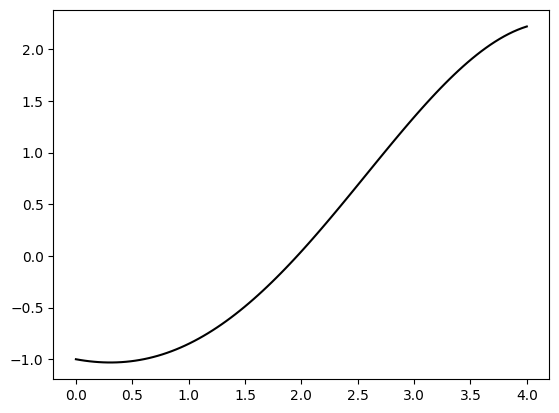

In [258]:
x = np.linspace(0.0, 4.0, 100)  # 6.0

plt.plot(x, true_function(x), 'k')

Now let's sample from this to get our dataset. We can do this by adding noise to the data that we grab, too, so it has some variation to it.

In [310]:
x_data = np.linspace(0.0,4.0,5) # 6.0
true_data = true_function(x_data)

# def random_func(x, dy=0.1):
#     return np.random.normal(true_function(x), dy)

y_data = true_function(x_data)#, dy=0.15)

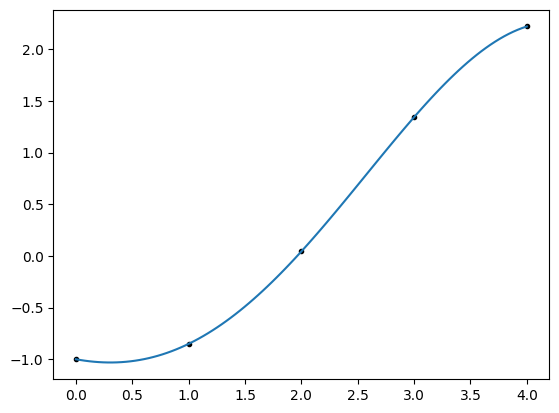

In [311]:
plt.plot(x_data, y_data, 'k.')
plt.plot(x, true_function(x))

Now we can simply take the result of the above plot and add some error bars to it, to symbolize errors.

In [312]:
np.random.seed(0)
y_err = np.diag(np.random.random(len(x_data)) * (0.35*np.eye(len(x_data))))

<ErrorbarContainer object of 3 artists>

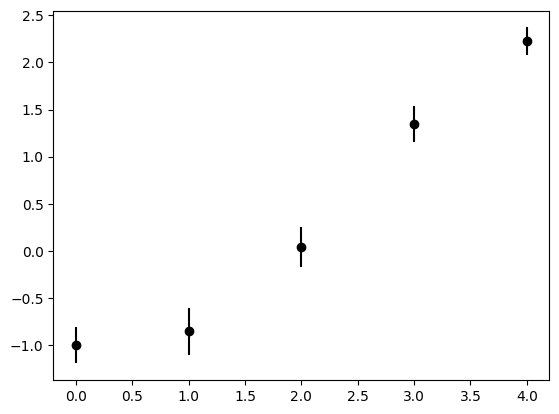

In [313]:
plt.plot(x_data, y_data, 'k.')
plt.errorbar(x_data, y_data, y_err, color='black', fmt='o')

## Adding a Gaussian process

Now we fit with a Gaussian process to get the curve, and then we'll try to get that same curve back using another GP, to see how things change.

1.59**2 * RBF(length_scale=2.18)


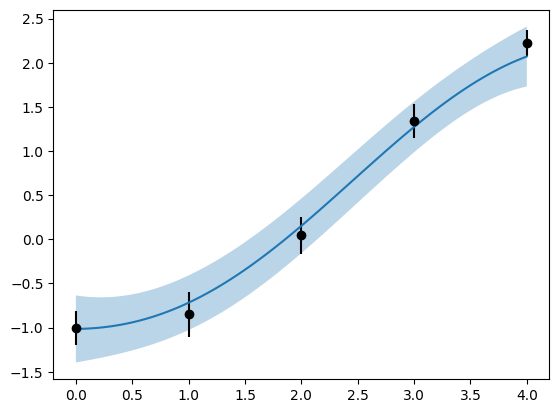

In [314]:
# calling sklearn 
kernel1 = ConstantKernel(1.0) * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(
    kernel = kernel1,
    alpha = y_err,
)

x_train = x_data.reshape(-1,1)
y_train = y_data.reshape(-1,1)

# fit the GP using the training data
gp.fit(x_train, y_train) 

# show the kernel parameters
print(gp.kernel_)

# predict using this GP on new prediction data
y_predict, y_std = gp.predict(x.reshape(-1,1), return_std=True)
_, y_cov = gp.predict(x.reshape(-1,1), return_cov=True)

# now plot the results
plt.errorbar(x_data, y_data, y_err, fmt='o', color='k')
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.show()

## Fitting this with another GP

Now we'd like to see a GP that is able to recover this error band and general shape. We'll need data points from this GP, to try this out.

(100, 100)


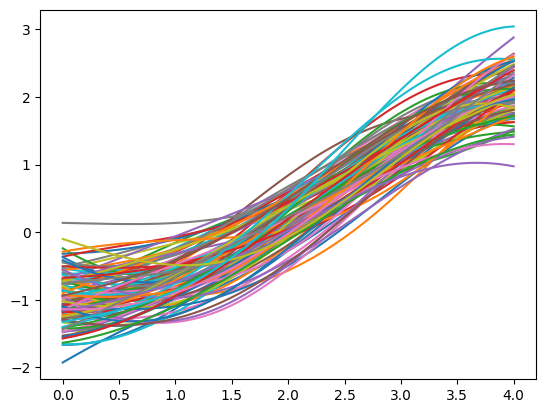

In [315]:
# getting points from this GP
samples = gp.sample_y(x.reshape(-1,1), 100)
print(samples.shape)
plt.plot(x, samples)
plt.show()

First, let's just take some data from the GP, using the mean and the covariance matrix. This will tell us if we cannot recover the mean easily using data from along it or not.

In [324]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr4 = x[2::15]
y_tr4 = y_predict[2::15]
y_trstd4 = y_std[2::15]
y_trcov4 = y_cov[2::15, 2::15]

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget = 1e-08*np.eye(len(x_tr4))

1.59**2 * RBF(length_scale=2.18)


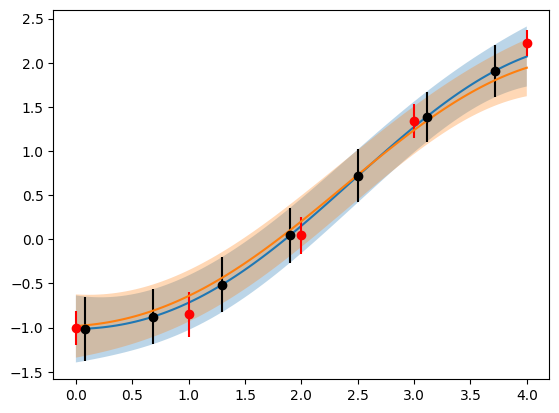

In [333]:
# train a new GP on this data and compare to the original
kernel2 = ConstantKernel(1.59**2.0, constant_value_bounds='fixed') * \
RBF(length_scale=2.18, length_scale_bounds='fixed')
gp2 = GaussianProcessRegressor2dNoise(
    kernel = kernel2,
    alpha = y_trcov4 + nugget,
)

gp2.fit(x_tr4.reshape(-1,1), y_tr4.reshape(-1,1), priors=False)

print(gp2.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred4, y_std4 = gp2.predict(x.reshape(-1,1), return_std = True)
_, y_cov4 = gp2.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.errorbar(x_data, y_data, y_err, fmt='o', color='r')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_pred4)
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.show()

In [334]:
# now let's check the width differences in the above error bands
width_true = (y_predict+y_std) - (y_predict-y_std)
width_7 = (y_pred4+y_std4) - (y_pred4-y_std4)

print('Relative error:\n', (np.abs((width_7 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_7 - width_true))/width_true)*100))

Relative error:
 [5.73149757 5.34111051 4.98872222 4.67736548 4.409461   4.18670596
 4.00998689 3.87932439 3.79385451 3.75184947 3.75077674 3.78739254
 3.85786331 3.95790646 4.08294132 4.22824065 4.38907459 4.56084021
 4.73917178 4.92002918 5.0997635  5.27516058 5.44346447 5.60238348
 5.75008195 5.88516088 6.00663038 6.11387666 6.2066258  6.28490607
 6.34901028 6.39945897 6.43696543 6.46240256 6.47677211 6.48117607
 6.47679031 6.46484024 6.44657838 6.42326358 6.3961418  6.36642828
 6.33529098 6.30383517 6.27308924 6.24399156 6.21737853 6.19397385
 6.174379   6.15906501 6.14836574 6.14247249 6.14143024 6.1451354
 6.15333527 6.16562908 6.18147074 6.20017323 6.22091473 6.24274636
 6.26460168 6.28530787 6.30359878 6.31812981 6.32749496 6.330246
 6.32491433 6.31003555 6.28417735 6.24597093 6.19414643 6.12757274
 6.04530186 5.94661795 5.83109083 5.69863335 5.54956142 5.38465497
 5.20521722 5.01312862 4.81089116 4.60165765 4.38924009 4.1780909
 3.97325152 3.78026366 3.60504112 3.45370297 3.33

OK, now let's see what happens if we instead use many more points than 7. Let's try using 25 of the total 100 in the original set.

In [327]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr50 = x[5::11]
y_tr50 = y_predict[5::11]
y_trstd50 = y_std[5::11]
y_trcov50 = y_cov[5::11, 5::11]

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget50 = 1e-08*np.eye(len(x_tr50))

0.47**2 * RBF(length_scale=9.67e+04)


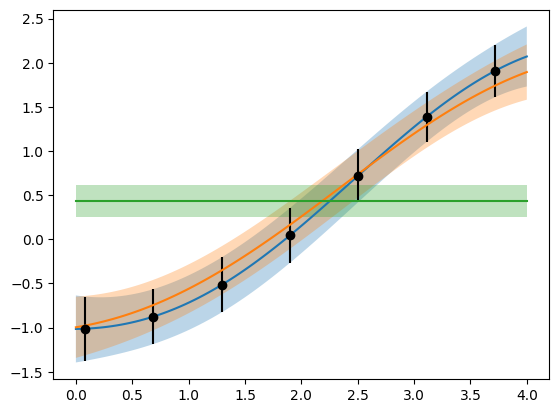

In [328]:
# train a new GP on this data and compare to the original
gp3 = GaussianProcessRegressor2dNoise(
    kernel = kernel1,
    alpha = y_trcov50 + nugget50,
)

gp3.fit(x_tr50.reshape(-1,1), y_tr50.reshape(-1,1), priors=False)

print(gp3.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred50, y_std50 = gp3.predict(x.reshape(-1,1), return_std = True)
_, y_cov50 = gp3.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_pred4)
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.plot(x, y_pred50)
plt.fill_between(x, y_pred50-y_std50, y_pred50+y_std50, alpha=0.3)
plt.show()

In [308]:
# now let's check the width differences in the above error bands
width_true = (y_predict+y_std) - (y_predict-y_std)
width_25 = (y_pred50+y_std50) - (y_pred50-y_std50)

print('Relative error:\n', (np.abs((width_25 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_25 - width_true))/width_true)*100))

Relative error:
 [ 9.92397118  9.27473269  8.6578613   8.07954204  7.54584431  7.06252735
  6.63482789  6.26724029  5.96330236  5.72540152  5.5546168   5.45061079
  5.4115828   5.43428997  5.51413755  5.64533364  5.82109828  6.03391263
  6.27579115  6.53855955  6.81412198  7.09470388  7.37306046  7.64264447
  7.89773086  8.13349906  8.34607605  8.53254519  8.69092621  8.82013254
  8.91991145  8.99077191  9.03390446  9.05109643  9.04464493  9.01726959
  8.97202614  8.91222178  8.84133278  8.76292473  8.68057568  8.59780261
  8.51799161  8.44433224  8.37975688  8.32688566  8.28797784  8.26489048
  8.25904503  8.27140253  8.30244782  8.35218295  8.42012983  8.50534165
  8.60642272  8.72155583  8.84853624  8.98481133  9.12752481  9.27356442
  9.4196124   9.56219768  9.69774954  9.82265215  9.93330015 10.02615515
 10.09780378 10.14501755 10.16481536 10.15452915 10.11187325 10.03501789
  9.92266668  9.7741376   9.58944623  9.36938899  9.11562323  8.83073962
  8.51832135  8.18298305  7.830381